# End-to-End Customer Churn Prediction System

## Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

## Step 2: Load Dataset

In [3]:
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)


print("Data Shape:", df.shape)
df.head()

Data Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 3: Exploratory Data Analysis (EDA)

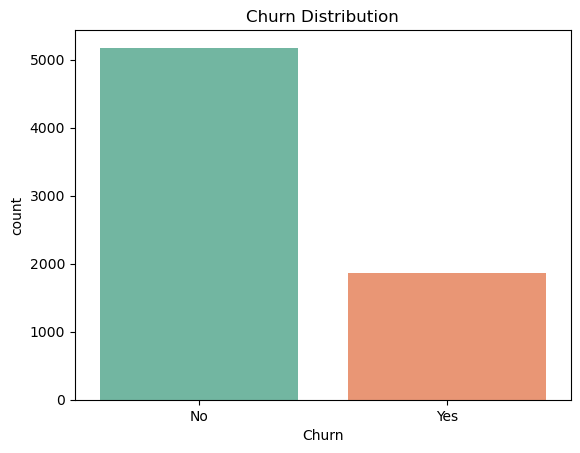

Churn Rate (%):
 Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


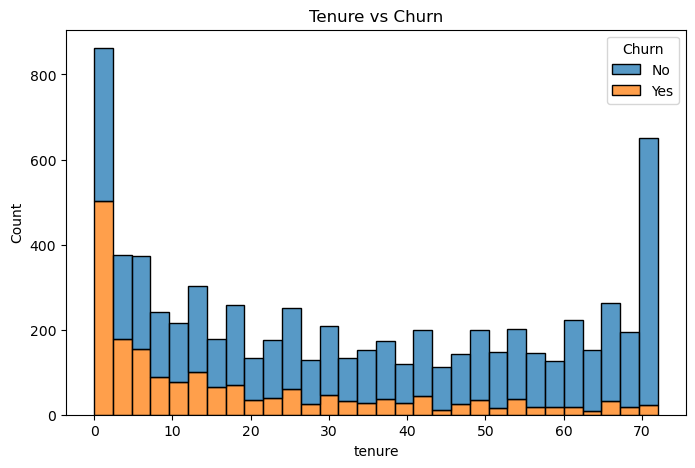

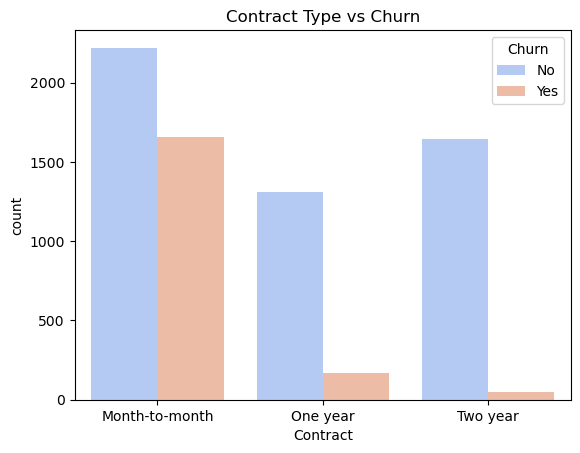

In [4]:
# Churn distribution
sns.countplot(x="Churn", data=df, palette="Set2")
plt.title("Churn Distribution")
plt.show()


# Churn rate
churn_rate = df["Churn"].value_counts(normalize=True) * 100
print("Churn Rate (%):\n", churn_rate)


# Tenure vs Churn
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="tenure", hue="Churn", multiple="stack", bins=30)
plt.title("Tenure vs Churn")
plt.show()


# Contract type vs Churn
sns.countplot(x="Contract", hue="Churn", data=df, palette="coolwarm")
plt.title("Contract Type vs Churn")
plt.show()

## Step 4: Data Preprocessing

In [5]:
# Handle missing values in TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


# Drop customerID (not useful for prediction)
df.drop("customerID", axis=1, inplace=True)


# Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)


# Features & Target
X = df_encoded.drop("Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]


# Scale numerical features
scaler = StandardScaler()
X_scaled = X.copy()
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Step 5: Model Building

In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Logistic Regression
print("===== Logistic Regression =====")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
evaluate_model(log_reg, X_test, y_test)

# Random Forest
print("===== Random Forest =====")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

# XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train XGBoost without deprecated parameter
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric="logloss",   # <-- added to avoid warning
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("===== XGBoost =====")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb))

===== Logistic Regression =====
              precision    recall  f1-score   support

       False       0.85      0.90      0.87      1035
        True       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8419979849647369
===== Random Forest =====
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1035
        True       0.63      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC-AUC: 0.8260766230075693
===== XGBoost =====
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1035
        True       0.63      0.53      0.58       374

    accuracy                           0.79     

## Model Selection (Choose Best)

In [9]:
# Compare by ROC-AUC
models = {"Logistic Regression": log_reg, "Random Forest": rf, "XGBoost": xgb}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name}: ROC-AUC = {auc:.4f}")

best_model = max(
    models, key=lambda name: roc_auc_score(y_test, models[name].predict_proba(X_test)[:,1])
)
print("Best Model:", best_model)


Logistic Regression: ROC-AUC = 0.8420
Random Forest: ROC-AUC = 0.8261
XGBoost: ROC-AUC = 0.8214
Best Model: Logistic Regression


## Step 7: Save Model

In [10]:
joblib.dump(models[best_model], "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!


## Step 8: Deployment Simulation

In [11]:
# Example input for prediction
sample = X_test.iloc[[0]]
pred_proba = models[best_model].predict_proba(sample)[0][1]
pred_label = "Likely to Churn" if pred_proba > 0.5 else "Not Likely to Churn"

print("Prediction Example:")
print("Probability:", round(pred_proba, 2))
print("Result:", pred_label)

Prediction Example:
Probability: 0.05
Result: Not Likely to Churn
